<a href="https://colab.research.google.com/github/Kmeco/offline-rl/blob/master/dataset_collection_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation

In the first few cells we'll start by installing all of the necessary dependencies (and a few optional ones).

In [ ]:
#@title Install necessary dependencies.

!sudo apt-get install -y xvfb ffmpeg
!pip install gym
!pip install wandb
!pip install imageio
!pip install PILLOW
!pip install pyglet
!pip install pyvirtualdisplay

!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[tf]
!pip install dm-acme[envs]

!pip3 install gym-minigrid

!pip uninstall -y tb-nightly tensorboardX tensorboard && pip install tensorboard

from IPython.display import clear_output
clear_output()

In [ ]:
!wandb login ... # put your own wandb api id here

In [ ]:
!rm -rf offline-rl
!git clone https://github.com/Kmeco/offline-rl.git
!cp -r offline-rl/experiments/* .

## Import Modules

Now we can import all the relevant modules.

In [ ]:
#@title Import modules.
#python3

%%capture
import copy
import wandb
import os
import pyvirtualdisplay
import imageio
import base64
import IPython
import tensorflow as tf
from absl import flags
import trfl 

from acme import environment_loop
from acme.tf import networks
from acme.adders import reverb as adders
from acme.agents.tf import actors as actors
from acme.datasets import reverb as datasets
from acme.wrappers import gym_wrapper
from acme import specs
from acme import wrappers
from acme.agents.tf import d4pg
from acme.agents import agent
from acme.tf import utils as tf2_utils
from acme.utils import loggers

import gym 
import dm_env
import matplotlib.pyplot as plt
import numpy as np
import reverb
import sonnet as snt

from gym_minigrid.register import env_list
from gym_minigrid.wrappers import FullyObsWrapper

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Train the online DQN agent

note that cql ran with alpha=0 is equivalent to a double-DQN

In [ ]:
!python run_online_cql.py --environment_name='MiniGrid-Empty-Random-6x6-v0' \
                          --n_episodes=500 \
                          --logs_tag='dqn-online-Empty-Random-6x6' \
                          --cql_alpha=0.0 \
                          --n_step_returns=1 \
                          --epsilon=0.1 \
                          --learning_rate=1e-4 \
                          --samples_per_insert=128 \
                          --ep_max_len=500 \
                          --max_replay_size=10000 \
                          --wandb_id=''

wandb: Tracking run with wandb version 0.9.6
wandb: Run data is saved locally in wandb/run-20200830_191359-1598809840
wandb: Syncing run 1598809840
wandb: ⭐️ View project at https://app.wandb.ai/kmeco/offline-rl
wandb: 🚀 View run at https://app.wandb.ai/kmeco/offline-rl/runs/1598809840
wandb: Run `wandb off` to turn off syncing.

I0830 19:14:00.632197 140221979920256 run_online_cql.py:51] Downloading model artifact from: kmeco/offline-rl/dqn-online-Empty-Random-6x6:latest
I0830 19:14:01.036281 140221979920256 run_online_cql.py:55] Model checkpoint downloaded to: /root/acme/4fe401d2-eae9-11ea-91f2-0242ac1c0002/
[reverb/cc/platform/tfrecord_checkpointer.cc:143] Initializing TFRecordCheckpointer in /tmp/tmp0ufzow1f
[reverb/cc/platform/tfrecord_checkpointer.cc:320] Loading latest checkpoint from /tmp/tmp0ufzow1f
[reverb/cc/platform/default/server.cc:55] Started replay server on port 18373
W0830 19:14:02.756154 140221979920256 ag_logging.py:146] Entity <function _yield_value at 0x7f87e7f4b6

## Collect offline dataset

In [ ]:
from tqdm.notebook import tqdm
import utils 
from visualization import display_video, render, plot_dataset_characteristics, _get_true_env_shape, evaluate_q, visualize_policy

#### Define an environment
Load an environemnt with the needed wrappers and render the first frame. 


(-0.5, 287.5, 223.5, -0.5)

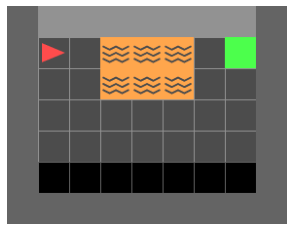

In [ ]:
env_name = "MiniGrid-DistShift1-v0" # @param ['MiniGrid-Empty-Random-6x6-v0', 'MiniGrid-DistShift1-v0', 'MiniGrid-SimpleCrossingS9N1-v0']
max_steps = 500 # @param

environment, environment_spec = utils._build_environment(env_name, max_steps=max_steps) 
# Show the frame.
environment.reset()
frame = render(environment)
plt.imshow(frame)
plt.axis('off')

#### Define an actor
Load the trained network from a wandb checkpoint and append an appropirate sampling head.

Existing agents in the WandB repo: \\

Lava: [acme_checkpoint][v9, v10] \\
Simple: [dqn-online-Empty-Random-6x6][latest]



In [ ]:
model_name = "acme_checkpoint" #@param {type:"string"}
model_tag = "v9" #@param {type:"string"}
loaded_network = utils.load_wb_model(model_name, model_tag)

In [ ]:
#@title Define the sampling head. { run: "auto" }
epsilon = 0.1 #@param {type:"slider", min:0, max:1, step:0.05}
stochastic =  False # @param {type:"boolean"}
if stochastic:
    head = networks.StochasticSamplingHead()
else:
    head = lambda q: trfl.epsilon_greedy(q, epsilon=epsilon).sample()

policy_network = snt.Sequential([
    loaded_network,
    head,
])

actor = actors.FeedForwardActor(policy_network)

**Alternatively**: define a random actor. 




In [ ]:
model_name = 'random' # @param 

actor = utils.RandomActor(environment_spec)

#### Visualisation
Use the loaded environment and actor to create num episodes to render a video. It can be used to double-check if the agent was trained correctly and behaves as expected.

In [ ]:
# Run the actor in the environment for desired number of steps.
frames = []
num_steps =  500 # @param 
timestep = environment.reset()

for _ in range(num_steps):
  frames.append(render(environment))
  action = actor.select_action(timestep.observation)
  timestep = environment.step(action)

# Save video of the behaviour.
display_video(np.array(frames))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <module '__main__'> is a built-in module
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <module '__main__'> is a built-in module
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


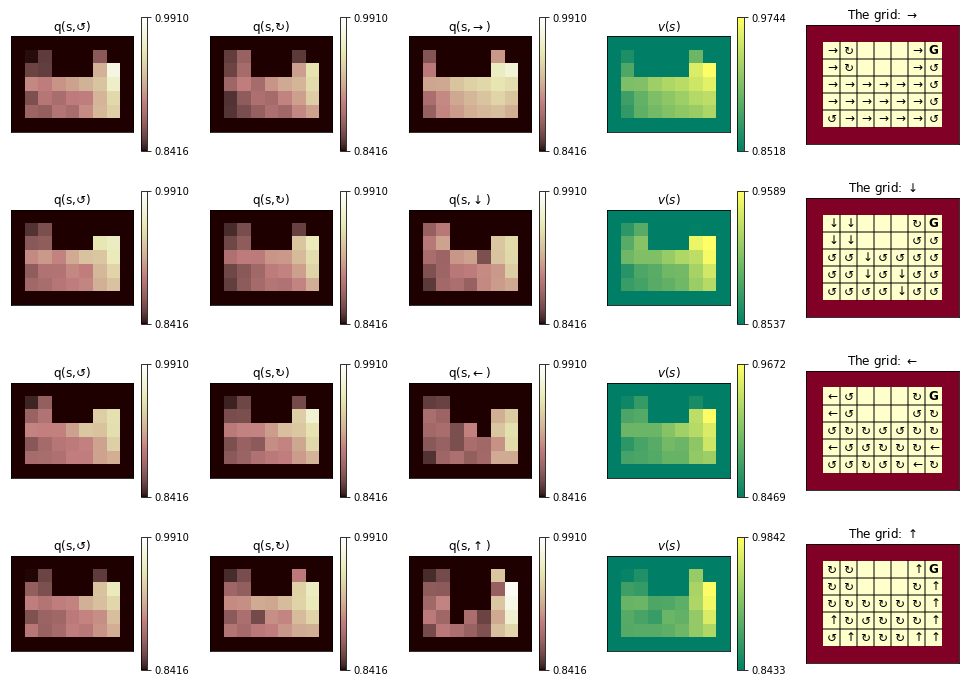

In [ ]:
Q = evaluate_q(loaded_network, environment)
plot = visualize_policy(Q, environment)

#### Collect dataset
Collect an offline dataset using the DemonstrationRecorder.

In [ ]:
n_episodes =  300 # @param 
save_dir = "datasets/" #@param {type:"string"}
custom_tag = "eps01-mix" #@param {type:"string"}
subsample_negative = 0 #@param {type:"number"}

dataset_name = model_name + '-' + custom_tag
save_path = os.path.join(save_dir, env_name, dataset_name)

recorder = utils.DemonstrationRecorder(environment, actor, subsample_negative)

recorder.collect_n_episodes(n_episodes)
# recorder.make_tf_dataset()
# recorder.save(save_path, overwrite=True)

100%|██████████| 300/300 [00:07<00:00, 41.97it/s]


In [ ]:
# don't run this if using the dataset generated above
import wandb, os
run = wandb.init()
environment_name = 'MiniGrid-DistShift1-v0' # @param ['MiniGrid-Empty-Random-6x6-v0', 'MiniGrid-DistShift1-v0']
dataset_tag = "dqn-online-DistShift1-eps0.3" #@param {type:"string"}

artifact = run.use_artifact(f'kmeco/offline-rl/{environment_name}:{dataset_tag}', type='dataset')
artifact_dir = artifact.download()

save_path = os.path.join(artifact_dir, dataset_tag)

100%|██████████| 1000/1000 [00:16<00:00, 59.84it/s]


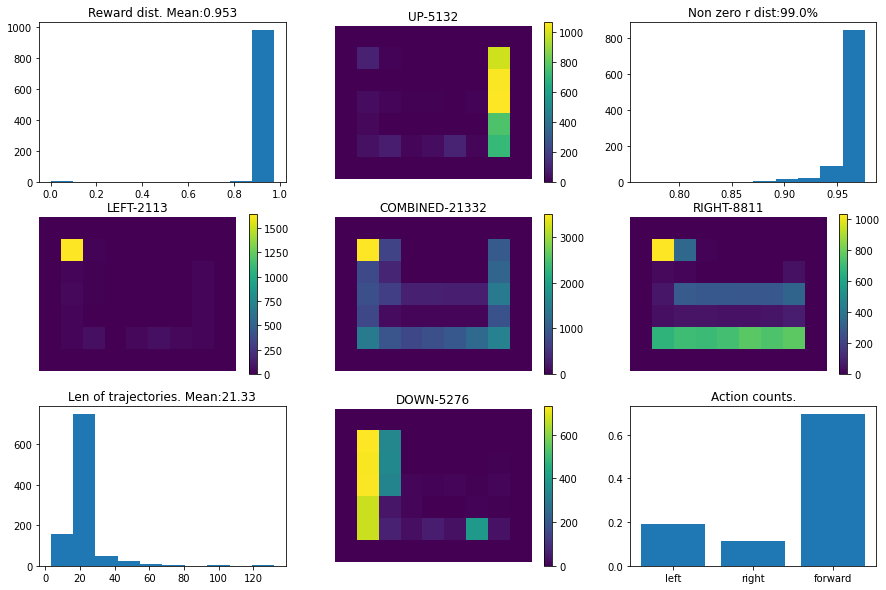

In [ ]:
dataset = utils.load_tf_dataset(save_path)
filter_negative = False #@param {type:"boolean"}

plot_dataset_characteristics(dataset,
                    _get_true_env_shape(environment),
                    filter_negative)

In [ ]:
wb_run = wandb.init(project="offline-rl")

artifact = wandb.Artifact(env_name, type='dataset')
artifact.add_dir(save_path, name=dataset_name)
wandb.run.log_artifact(artifact, aliases=['latest', dataset_name])

wandb: Adding directory to artifact (./datasets/MiniGrid-DistShift1-v0/acme_checkpoint-eps01-mix)... Done. 0.1s
